# StreetViewGAN - Translating Between Maps Facades and Real World Images

In [1]:
import os
import numpy as np
from torch.utils.data import DataLoader
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.auto import tqdm
from IPython.display import Image
import matplotlib.pyplot as plt
import pathlib
import tarfile
import urllib.request
%matplotlib inline

2025-06-10 15:16:58.411920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749568618.446416   29718 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749568618.454560   29718 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749568618.482252   29718 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749568618.482272   29718 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749568618.482275   29718 computation_placer.cc:177] computation placer alr

## Download the Dataset

In [2]:
dataset_name = "maps"
_URL = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz"

# Download and extract the dataset
def download_and_extract(url, download_path):
    if not download_path.exists():
        print(f"Downloading {url}...")
        tar_path, _ = urllib.request.urlretrieve(url)
        print(f"Extracting to {download_path}...")
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=download_path.parent)
    else:
        print(f"{dataset_name} already downloaded.")

# Set paths
base_path = pathlib.Path('./data')
download_path = base_path / dataset_name
base_path.mkdir(exist_ok=True)

download_and_extract(_URL, download_path)

# Now dataset is available at:
print("Dataset path:", download_path)

Extracting to data/maps...
Dataset path: data/maps


## Data Preprocessing

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

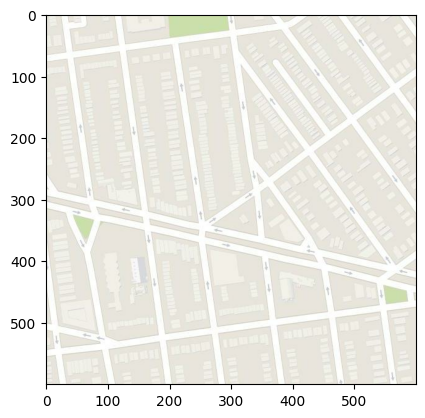

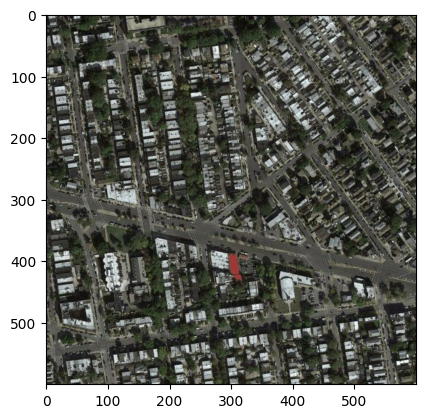

In [6]:
i, o = load("/workspaces/StreetViewGAN-Translating-Between-Maps-Facades-and-Real-World-Images/data/maps/train/1.jpg")
plt.figure()
plt.imshow(i / 255.0)
plt.figure()
plt.imshow(o / 255.0)

In [ ]:
# Define hyperparameters
image_size = 256        # Standard for Pix2Pix
batch_size = 64          
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB images to [-1, 1]


In [ ]:
# Compose transforms
data_transform = T.Compose([
    T.Resize(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [ ]:
# Create DataLoader (CPU-only)
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=False  # pin_memory only helps GPU transfers
)

In [ ]:
# Denormalization helper
def denorm(imgs):
    """Map from [-1,1] to [0,1]"""
    return imgs * stats[1][0] + stats[0][0]

In [ ]:
# Display single image
def show_images(images, nmax=64):
    grid = make_grid(denorm(images[:nmax]), nrow=8)
    np_grid = grid.detach().cpu().permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(np_grid)
    plt.show()

## Visualizing a Batch of Real Images

In [ ]:
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
show_batch(train_dl)